In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [ ]:
# I create image generators for each of the three image data sets.
# Use ImageDataGenerator to read / decode the images and convert them into floating point tensors.
train_image_generator = ImageDataGenerator(
    rescale = 1./255,
    )

validation_image_generator = ImageDataGenerator(
    rescale = 1./255,
    )

test_image_generator = ImageDataGenerator(
    rescale = 1./255,
    )

# Arguments
data_gen_arg = dict(
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = batch_size,
    class_mode = 'binary',
    )

train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    subset='training',
    **data_gen_arg
    )

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    **data_gen_arg
    )

test_data_gen = test_image_generator.flow_from_directory(
    PATH,
    classes = ['test'],
    shuffle = False,
    **data_gen_arg
    )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


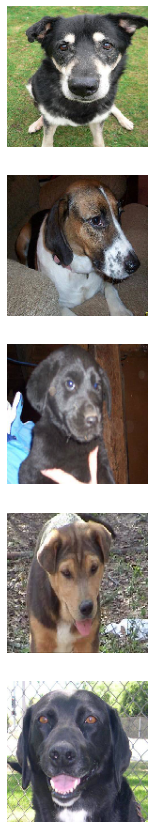

In [ ]:
# This cell will plot five random training images.
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [ ]:
# I recreate the train_image_generator using ImageDataGenerator.
# Since there are a small number of training examples, there is a risk of overfitting.
# One way to fix this problem is by creating more training data from existing 
# training examples by using random transformations.

train_image_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 25,
    shear_range = .15,
    zoom_range = .20,
    height_shift_range = .2,
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split = .2,
    )

Found 2000 images belonging to 2 classes.


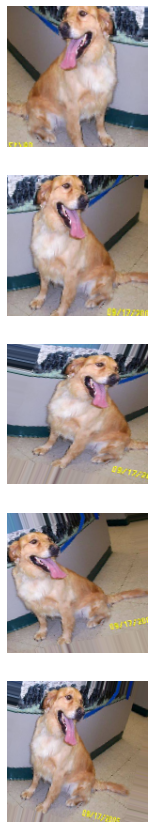

In [ ]:
# A single image is plotted five different times using different variations.
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [ ]:
# I create a model for the neural network that outputs class probabilities. 
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))

model.add(Dense(4, activation = 'sigmoid'))


model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 82944)             0         
                                                                 
 dense_21 (Dense)            (None, 64)               

In [ ]:
# Now, I train the network.
history = model.fit(
    train_data_gen,
    epochs = epochs,
    steps_per_epoch = total_train // batch_size,
    validation_data = val_data_gen,
    validation_steps = total_val // batch_size
    )

Epoch 1/15
15/15 [==============================] - 19s 1s/step - loss: 1.7567 - accuracy: 0.4802 - val_loss: 0.8086 - val_accuracy: 0.5011
Epoch 2/15
15/15 [==============================] - 17s 1s/step - loss: 0.7245 - accuracy: 0.5353 - val_loss: 0.7611 - val_accuracy: 0.4922
Epoch 3/15
15/15 [==============================] - 17s 1s/step - loss: 0.6822 - accuracy: 0.5577 - val_loss: 0.7255 - val_accuracy: 0.5134
Epoch 4/15
15/15 [==============================] - 17s 1s/step - loss: 0.6751 - accuracy: 0.5855 - val_loss: 0.6561 - val_accuracy: 0.6194
Epoch 5/15
15/15 [==============================] - 18s 1s/step - loss: 0.6498 - accuracy: 0.6197 - val_loss: 0.6289 - val_accuracy: 0.6440
Epoch 6/15
15/15 [==============================] - 20s 1s/step - loss: 0.6246 - accuracy: 0.6597 - val_loss: 0.6205 - val_accuracy: 0.6194
Epoch 7/15
15/15 [==============================] - 17s 1s/step - loss: 0.6064 - accuracy: 0.6619 - val_loss: 0.5813 - val_accuracy: 0.6819
Epoch 8/15
15/15 [==

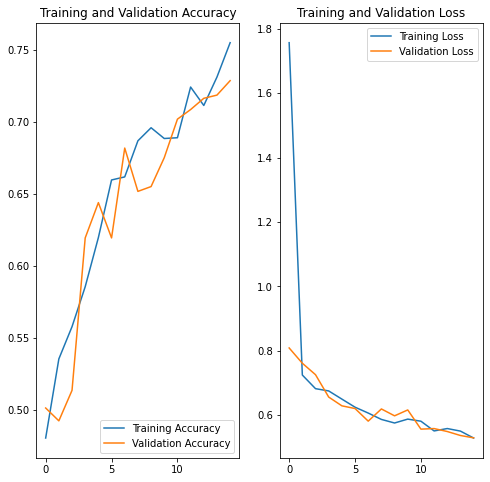

In [ ]:
# I visualize the accuracy and loss of the model.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
probabilities = np.argmax(model.predict(test_data_gen), axis=-1)

1/1 [==============================] - 0s 149ms/step


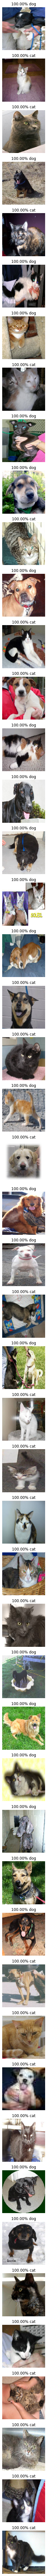

In [ ]:
plotImages(test_data_gen[0][0], probabilities)

In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 76.0% of the images of cats and dogs.
You passed the challenge!
